μ_RA*  = 10.09 ± 7.22 mas/yr
μ_Dec  = 13.40 ± 6.38 mas/yr
|μ|     = 16.77 ± 6.70 mas/yr
Δt      = 3.997 yr


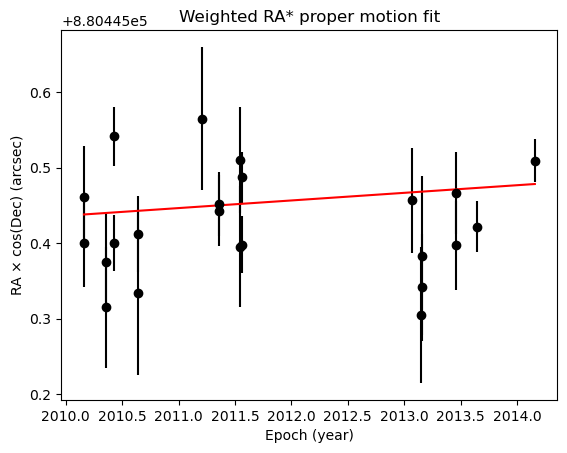

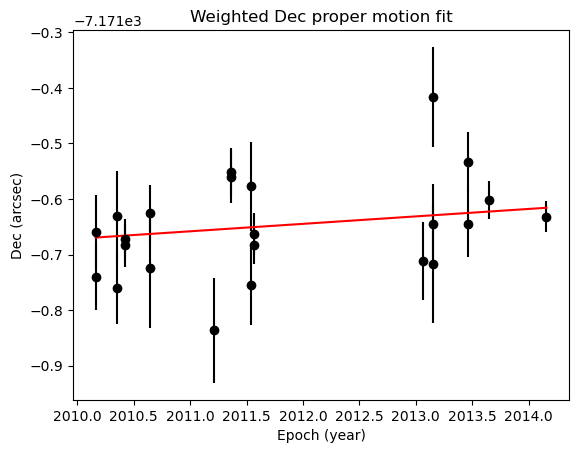

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from astropy.time import Time
import math

# Load your PS1 detections
df = pd.read_csv("detections/prop_motion.csv")

# Convert MJD → decimal year
df["epoch"] = Time(df["obsTime"], format="mjd").decimalyear

# Sort by epoch
df = df.sort_values("epoch")

# Extract arrays
t       = df["epoch"].values
ra_deg  = df["ra"].values
dec_deg = df["dec"].values

# Errors from PS1: usually in arcseconds
ra_err_arcsec  = df["raErr"].values
dec_err_arcsec = df["decErr"].values

# Mean Dec for cos(dec) correction
cosd = np.cos(np.deg2rad(np.mean(dec_deg)))

# Convert RA & Dec to arcseconds
ra_arcsec  = ra_deg  * cosd * 3600.0
dec_arcsec = dec_deg * 3600.0

# Weighted linear fit:
# y = a*t + b   with weights = 1/sigma^2

# RA fit
weights_ra = 1.0 / (ra_err_arcsec**2)
coef_ra, cov_ra = np.polyfit(t, ra_arcsec, 1, w=weights_ra, cov=True)

# Dec fit
weights_dec = 1.0 / (dec_err_arcsec**2)
coef_dec, cov_dec = np.polyfit(t, dec_arcsec, 1, w=weights_dec, cov=True)

# Slopes = proper motion (arcsec/yr)
mu_ra_arcsecyr  = coef_ra[0]
mu_dec_arcsecyr = coef_dec[0]

# Convert to mas/yr
mu_ra_masyr  = mu_ra_arcsecyr  * 1000.0
mu_dec_masyr = mu_dec_arcsecyr * 1000.0

# Uncertainties from covariance matrix
err_mu_ra  = np.sqrt(cov_ra[0,0])  * 1000.0
err_mu_dec = np.sqrt(cov_dec[0,0]) * 1000.0

# Total proper motion
mu_tot = math.hypot(mu_ra_masyr, mu_dec_masyr)

# Uncertainty in total proper motion
mu_tot_err = math.sqrt(
    (mu_ra_masyr / mu_tot)**2 * err_mu_ra**2 +
    (mu_dec_masyr / mu_tot)**2 * err_mu_dec**2
)

print(f"μ_RA*  = {mu_ra_masyr:.2f} ± {err_mu_ra:.2f} mas/yr")
print(f"μ_Dec  = {mu_dec_masyr:.2f} ± {err_mu_dec:.2f} mas/yr")
print(f"|μ|     = {mu_tot:.2f} ± {mu_tot_err:.2f} mas/yr")

print(f"Δt      = {t.max() - t.min():.3f} yr")

# ---- OPTIONAL PLOTS ----
# RA plot
plt.figure()
plt.errorbar(t, ra_arcsec, yerr=ra_err_arcsec, fmt='o', color='black')
plt.plot(t, np.polyval(coef_ra, t), color='red')
plt.xlabel("Epoch (year)")
plt.ylabel("RA × cos(Dec) (arcsec)")
plt.title("Weighted RA* proper motion fit")
plt.show()

# Dec plot
plt.figure()
plt.errorbar(t, dec_arcsec, yerr=dec_err_arcsec, fmt='o', color='black')
plt.plot(t, np.polyval(coef_dec, t), color='red')
plt.xlabel("Epoch (year)")
plt.ylabel("Dec (arcsec)")
plt.title("Weighted Dec proper motion fit")
plt.show()


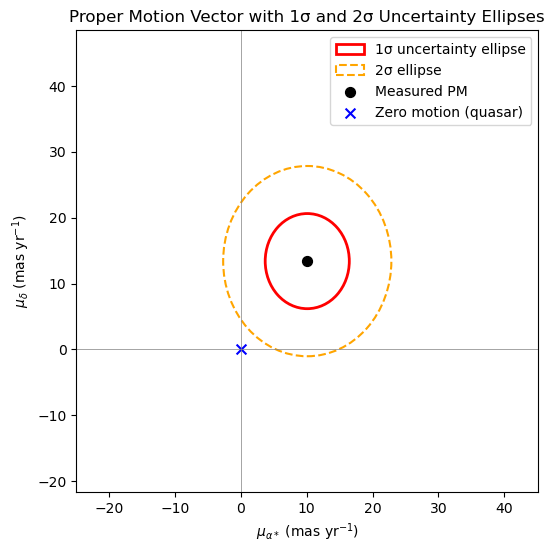

In [8]:
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

# --- Proper motion vector ---
mu_alpha = mu_ra_masyr
mu_delta = mu_dec_masyr

# --- Uncertainties ---
sigma_alpha = err_mu_ra
sigma_delta = err_mu_dec

# If you want to assume no covariance between RA* and Dec, set:
cov_alpha_delta = 0.0  # mas^2 / yr^2

# Construct covariance matrix
cov_matrix = np.array([
    [sigma_alpha**2,        cov_alpha_delta],
    [cov_alpha_delta,       sigma_delta**2]
])

# --- Eigen-decomposition to get ellipse axes ---
eigvals, eigvecs = np.linalg.eigh(cov_matrix)

# The eigenvalues are the variances along ellipse axes:
axis1 = np.sqrt(eigvals[0])   # 1σ major axis
axis2 = np.sqrt(eigvals[1])   # 1σ minor axis

# Angle of ellipse (radians → degrees)
angle = np.degrees(np.arctan2(eigvecs[1,1], eigvecs[0,1]))

# --- Create plot ---
fig, ax = plt.subplots(figsize=(6,6))

# Plot the 1σ error ellipse
ellipse_1sigma = Ellipse(
    (mu_alpha, mu_delta),
    width=2*axis1,           # full width
    height=2*axis2,          # full height
    angle=angle,
    edgecolor='red',
    facecolor='none',
    linewidth=2,
    label='1σ uncertainty ellipse'
)

# Plot the 2σ ellipse
ellipse_2sigma = Ellipse(
    (mu_alpha, mu_delta),
    width=2*axis1*2,
    height=2*axis2*2,
    angle=angle,
    edgecolor='orange',
    facecolor='none',
    linestyle='--',
    linewidth=1.5,
    label='2σ ellipse'
)

ax.add_patch(ellipse_1sigma)
ax.add_patch(ellipse_2sigma)

# Plot the measured proper motion point
ax.scatter(mu_alpha, mu_delta, color='black', s=50, label='Measured PM')

# Mark the zero-motion point (quasar expectation)
ax.scatter(0, 0, color='blue', s=50, marker='x', label='Zero motion (quasar)')

# Labels and limits
ax.set_xlabel(r'$\mu_{\alpha*}$ (mas yr$^{-1}$)')
ax.set_ylabel(r'$\mu_\delta$ (mas yr$^{-1}$)')
ax.axvline(0, color='gray', linewidth=0.5)
ax.axhline(0, color='gray', linewidth=0.5)

# Expand axes so ellipses fit nicely
max_range = max(abs(mu_alpha), abs(mu_delta)) + 3*max(sigma_alpha, sigma_delta)
ax.set_xlim(mu_alpha - max_range, mu_alpha + max_range)
ax.set_ylim(mu_delta - max_range, mu_delta + max_range)

ax.set_aspect('equal', 'box')
ax.legend()
plt.title("Proper Motion Vector with 1σ and 2σ Uncertainty Ellipses")
plt.show()
